In [1]:
from constants import *
from utility_functions import *
from plot_functions import *
from decoding_approaches import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import vonmises, poisson
import math
from numpy.linalg import norm

### Preffered HDs for each neuron

In [3]:
phases = get_evenly_spaced_phases(num_neurons, plot=False, rad=True)

### [OU] Input HDs and HDAVs 

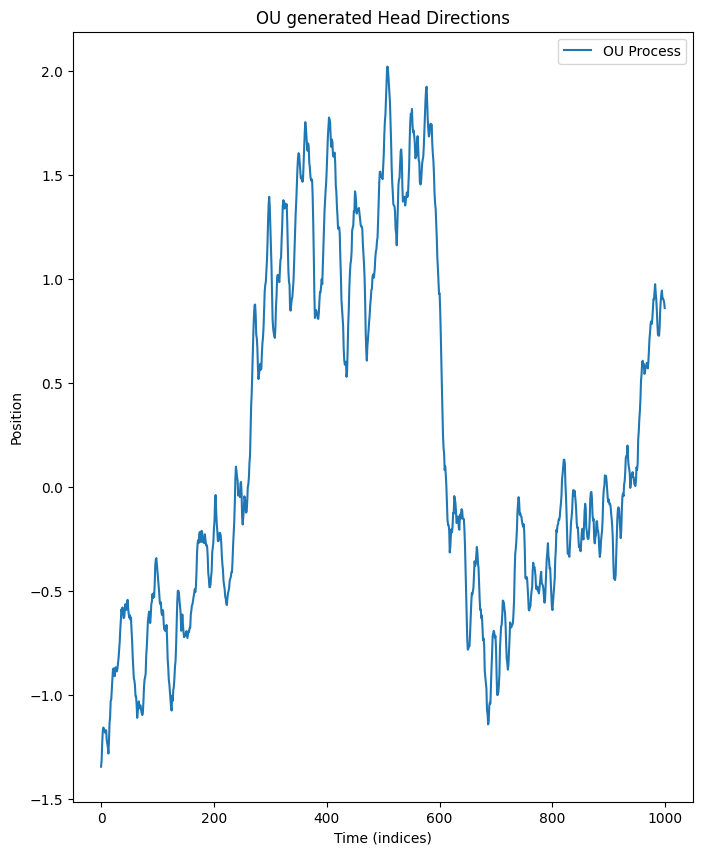

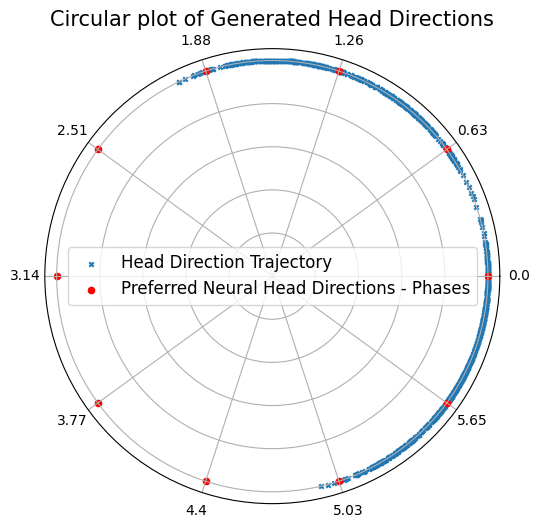

In [4]:
# OU process
x0 = np.random.randn()
v0 = np.random.randn()
positions, velocities = get_OU_inputs(x0, v0, num_positions, dt, tau, mu, sigma)
miliseconds = np.arange(0, T_ms, 10).astype(int)
plt_positions_uncirculated(positions, num_positions, dt, title='OU generated Head Directions')

# Mapping positions on a circle
circ_positions = circular_positions(positions, num_positions)
plt_circulated_pos(circ_positions, phases)


### Von Mises Firing Rates

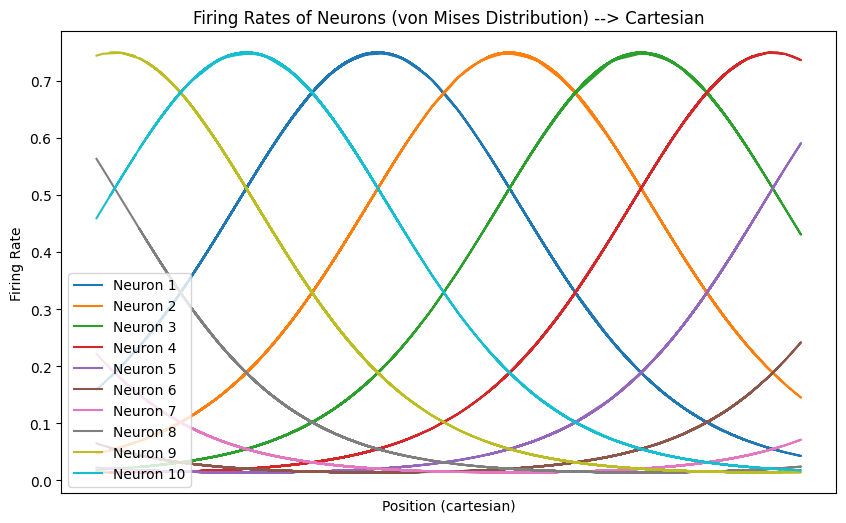

In [5]:
firing_rates_p = np.zeros((num_neurons, num_positions)) # cartesian
firing_rates_cp = np.zeros((num_neurons, num_positions)) # circular

for pos in range(num_positions):
    firing_rates_p[:, pos] = compute_firing_rates_VM(positions[pos], phases, scaling, kappa, max_firing_rate)
    firing_rates_cp[:, pos] = compute_firing_rates_VM(circ_positions[pos], phases, scaling, kappa, max_firing_rate)


plt_firing_rates_VM(positions, num_neurons, firing_rates_p, num_positions, title='Cartesian')
# plt_firing_rates_VM(circ_positions, num_neurons, firing_rates_cp, num_positions, title='Circluar')

### Generating Poisson Spike Counts

In [6]:
### Aggregating HDs and AHDVs into time chuncks of size sc_time_step ---- Computing Spike Counts

# in one tw i have sc_time_steps positions

In [7]:
# !! num_positions must be divisible w/ sc_time_step bc of reshaping the original_positions
num_time_windows = math.ceil(num_positions/sc_time_step)
spike_counts = np.zeros((num_time_windows, num_neurons))
decoded_positions = np.zeros(num_time_windows)
final_decodings = np.zeros(num_time_windows)


# --------------------------------------------------------------------
fr_sums = np.zeros((num_time_windows, num_neurons))
tw_original_positions = circ_positions.reshape(num_time_windows, -1)  # this uses circ pos
tw_original_positions_cartesian = positions.reshape(num_time_windows, -1)  # this uses cartesian pos
aggregated_velocities = np.mean(velocities.reshape(-1, sc_time_step), axis=1)  # If sc_time_step != 1

In [8]:
num_time_windows == num_positions

True

Dropouts: w or w\ ?

In [9]:
for time_window in range(num_time_windows):
    for neuron in range(num_neurons):                                       # sliding through the time windows
        fr_sums[time_window][neuron] = sum(firing_rates_cp[neuron][ time_window*sc_time_step : (time_window+1)*sc_time_step] )
        proba = np.random.random() if dropout else 1
        spike_counts[time_window][neuron] = poisson.rvs(fr_sums[time_window][neuron], sc_time_step) if proba > dropout_proba else 0

### Population Vector Decoding

In [11]:
approach_name = 'Population Vector'
pv_lengths = np.zeros(num_time_windows) # storing magnitudes of pv vector per time window 
decode_positions(decoded_positions, weighted_sum_approach, spike_counts, phases, pv_lengths) # for every time window I get a pv angle estimate, and pv certainty est
decoded_pos_unwraped = np.unwrap(decoded_positions)

/Users/jovan/Fax/Treca_godina/LMU/Codes/Ring_model/decoding_approaches.py:12: RuntimeWarning: invalid value encountered in scalar divide
  pv = np.sum(assigned_vector) / np.sum(weights) # this gives me a complex num; radius and a phase


-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

### Final Decoding using Extrapolation

In [12]:
colors = {'PV': 'magenta', 'Extrapolation': 'y', 'OG': 'b'}
final_decodings = np.zeros(num_time_windows)

final_decodings[:2] = positions[:2]
decoding_colors = np.array([colors['OG'] for _ in range(num_time_windows)]) # init

for i in range(2, num_time_windows):
    if pv_lengths[i] > pv_decoding_threshold:
        final_decodings[i] = decoded_pos_unwraped[i]
        decoding_colors[i] = colors['PV']
    else:
        final_decodings[i] = extrapolate_HD(positions, i)
        decoding_colors[i] = colors['Extrapolation']

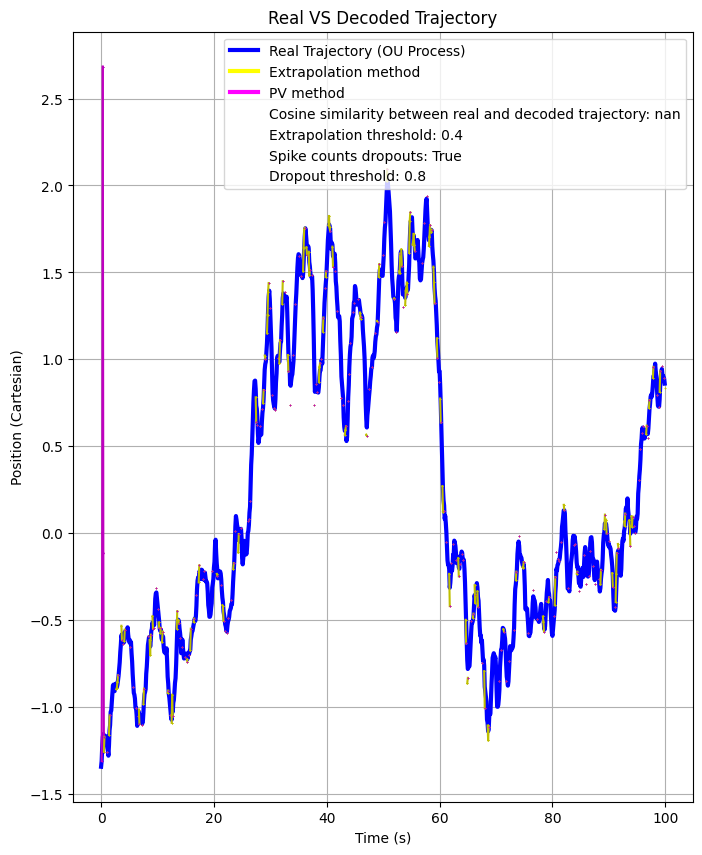

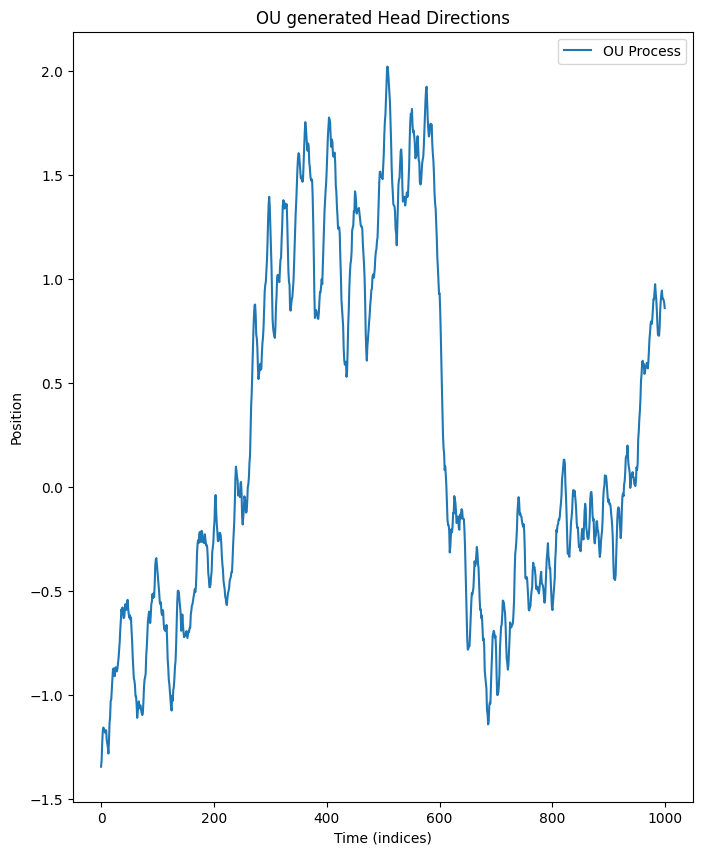

In [13]:
PV_plot_trajectory_comparison(positions, final_decodings, num_positions, decoding_colors, pv_decoding_threshold, dropout, dropout_proba, dt=dt, title='Real VS Decoded Trajectory')
plt_positions_uncirculated(positions, num_positions, dt, title='OU generated Head Directions')